# Ensembles

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

import astropy
from astropy.io import ascii
from astropy.table import Table

from sklearn.datasets import make_blobs
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from utils import plot_classifier_decision

# prepare toy samples for demo below
X, y = make_blobs(n_samples=200, centers=[[0, 1], [2, 3]], random_state=23)

## Read flight delay data

In [2]:
data        = ascii.read("data/training.csv", delimiter=',')
test_kaggle = ascii.read("data/test.csv", delimiter=',')

binary_target = (data['ARRIVAL_DELAY'] > 10) * 1
data.remove_column('ARRIVAL_DELAY')

### helping functions from the first notebook

In [3]:
def train_test_split(*arrays, **kargs):
    '''modification of sklearn's train_test_split to support astropy. See sklearn documentation for parameters '''
    from sklearn.cross_validation import train_test_split
    arrays2 = map(lambda x: numpy.array(x) if isinstance(x, Table) else x, arrays)
    results = list(train_test_split(*arrays2, **kargs))
    
    for i in range(len(results) // 2):
        if isinstance(arrays[i], Table):
            results[2 * i] = Table(results[2 * i])
            results[2 * i + 1] = Table(results[2 * i + 1])
    return results

In [4]:
from IPython.display import FileLink

def create_solution(predictions, filename='flight-delay-predictions.csv'):
    result = astropy.table.Table({'ID': numpy.arange(len(predictions)), 'ARRIVAL_DELAY': predictions})
    result.write('data/{}'.format(filename), format='csv', delimiter=',', overwrite=True)
    return FileLink('data/{}'.format(filename))

Take the same part of the flights data as in the previous notebooks and preparing training and test parts

In [5]:
# take small part of the data
small_data = data[::20]
small_binary_target = binary_target[::20]
print len(small_data)

# cross validation samples preparing
trainX, testX, trainY, testY = train_test_split(small_data, small_binary_target, random_state=42, train_size=0.5)

24994


/Users/axelr/.venvs/rep/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Random Forest

Builds independently many trees. 

Each tree is trained on a part of training data obtained by 
- sampling features (columns) without replacements (**Random Subspace Model**)
- sampling events (rows) with replacement (**bagging**)

### Demo

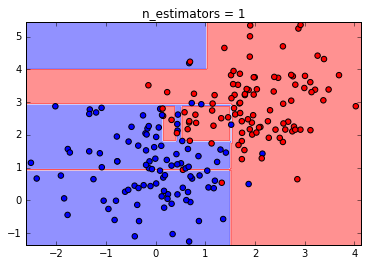

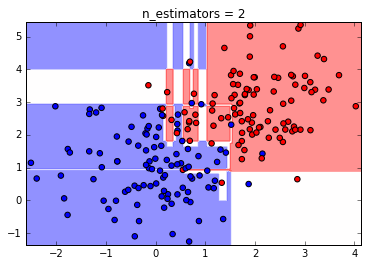

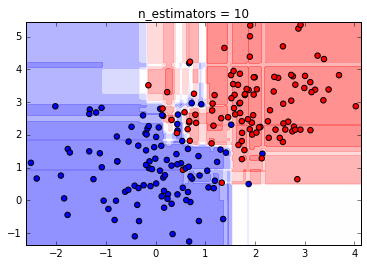

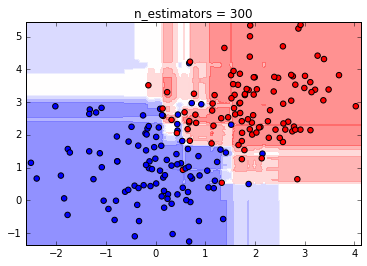

In [6]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
for n_trees in [1, 2, 10, 300]:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42).fit(X, y)
    plot_classifier_decision(rf, X, y)
    plt.title('n_estimators = {}'.format(n_trees))
    plt.show()

## Overfitting 

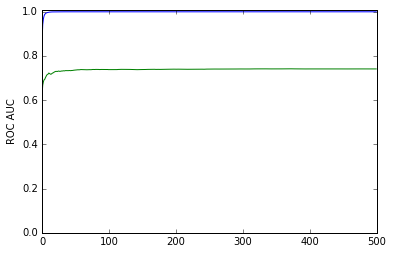

In [7]:
# defining toy datasets
toy_trainX, toy_trainY = make_blobs(n_samples=2000, centers=[[0, 1, 1], [1, 2, 2]], random_state=42, cluster_std=1.5)
toy_testX,  toy_testY  = make_blobs(n_samples=2000, centers=[[0, 1, 1], [1, 2, 2]], random_state=3,  cluster_std=1.5)
# train random forest
rf = RandomForestClassifier(n_estimators=500).fit(toy_trainX, toy_trainY)


# compute the ROC AUC after adding one more estimator in the ensemble
for toyX, toyY, label in [(toy_trainX, toy_trainY, 'train'), (toy_testX, toy_testY, 'test')]:
    predictions = numpy.zeros(len(toyX))
    curve = []
    for tree in rf.estimators_:
        predictions += tree.predict(toyX)
        curve.append(roc_auc_score(toyY, predictions))
    plt.plot(curve)
    plt.ylim(0, 1.01)
    plt.ylabel('ROC AUC')

### Random Forest
- terribly simple
- has huge difference of the quality between predictions on train and validation sample
- it's quality never goes down with increasing the number of trees
- **never overfits**
    - huge difference between predictions on test and training does not imply the model is bad, RF is such model

## also...
- RF efficiently works with features of different scale and nature
- doesn't require (much) tuning 
- for large datasets may produce giant trees (which is long and takes lots of memory). <br />
  Makes sense to limit growth of trees (`max_depth` or `min_samples_leaf`)
- works well in many situations.

# Random forest for flight delay

In [8]:
rf = RandomForestClassifier(n_estimators=200).fit(trainX.to_pandas(), trainY)
print 'test', roc_auc_score(testY, rf.predict_proba(testX.to_pandas())[:, 1])

test 0.623484174797


In [9]:
# look at the features importance
for feature, importance in zip(trainX.colnames, rf.feature_importances_):
    print feature, importance

MONTH 0.0604718206184
DAY 0.0905937392423
DAY_OF_WEEK 0.0531008246024
AIRLINE_ID 0.0432117472351
FLIGHT_NUMBER_ID 0.114112671486
TAIL_NUMBER_ID 0.11855194031
ORIGIN_AIRPORT_ID 0.0888313032524
DESTINATION_AIRPORT_ID 0.0911495982497
SCHEDULED_DEPARTURE 0.114085845108
DISTANCE 0.106663660628
SCHEDULED_ARRIVAL 0.119226849268


There are `SCHEDULED_DEPARTURE` and `SCHEDULED_ARRIVAL` among the most important features.

# AdaBoost (Adaptive Boosting) 

AdaBoost operates by reweighting samples each time. <br />
Weight of sample is increased if base classifier makes a mistake.

Formally this corresponds to minimizing exponential loss function.

Interface example to operate with AdaBoost in `sklearn`

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
# define Ada Boost classifier over Decision Trees
clf = AdaBoostClassifier(n_estimators=100, 
                         base_estimator=DecisionTreeClassifier(max_depth=3))

# you can train AdaBoost over other classifiers
clf = AdaBoostClassifier(n_estimators=100, 
                         base_estimator=GaussianNB())

# Gradient Boosting (GB) demonstration

GBDT approximates target dependency by making steps in the space of functions:

* [GB explanation](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
* [GB classification playground](http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html)
    * play with it to understand the most important knobs and tricks of GB

AdaBoost is a particular case of Gradient Boosting.

GB = GBDT = GBRT = GBM = MART, these are names of same approach.

## Working with GB in sklearn

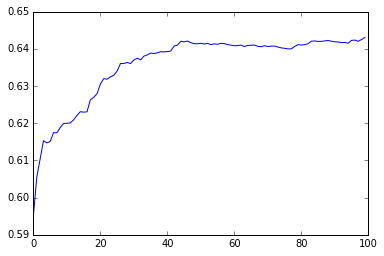

In [11]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
# define the Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
# fit the GB
gb_clf.fit(trainX.to_pandas(), trainY)

# compute qualtity, ROC AUC, after adding one more estimator into the ensemble
# use for this `staged_predict_proba` - iterator over predictions on each boosting iteration
test_qualities = []
for p in gb_clf.staged_predict_proba(testX.to_pandas()):
    test_qualities.append(roc_auc_score(testY, p[:, 1]))
plt.plot(test_qualities)

In [12]:
roc_auc_score(testY, gb_clf.predict_proba(testX.to_pandas())[:, 1])

0.64306314241932849

# XGBoost

It is another popular implementation of Gradient Boosting, which
- supports regularization
- uses hessian during optimization 
- supports sklearn interface
- works faster

In [13]:
from xgboost.sklearn import XGBClassifier

# define model as usual
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
# call fit as usual
xgb_clf.fit(trainX.to_pandas(), trainY)
# predict and compute roc auc
roc_auc_score(testY, xgb_clf.predict_proba(testX.to_pandas())[:, 1])

0.64551969503703577

In [14]:
create_solution(xgb_clf.predict_proba(test_kaggle.to_pandas())[:, 1], filename='flight-delay-xgb.csv')

/Users/axelr/Yandex.Disk.localized/2017-04-Heidelberg/practice/data/flight-delay-xgb.csv

# Categorical features preprocessing

trees can't efficiently use IDs, so we have several (combinable) options. <br />
Let's discuss those one-by-one


### 1) Replace category value by the respective count frequencies of this category in the column.

In [15]:
categorical_features = ['MONTH', 'DAY', 'DAY_OF_WEEK', 
                        'AIRLINE_ID', 'FLIGHT_NUMBER_ID', 'TAIL_NUMBER_ID',
                        'ORIGIN_AIRPORT_ID', 'DESTINATION_AIRPORT_ID']

In [16]:
trainX_ext = trainX.copy()
testX_ext = testX.copy()

for feature in categorical_features:
    length = max(numpy.max(trainX_ext[feature]), numpy.max(testX_ext[feature])) + 1
    # compute frequency of each value in category
    counts = numpy.bincount(trainX_ext[feature], minlength=length)
    # add columns with frequencies
    trainX_ext[feature + '_freq'] = counts[trainX_ext[feature]]
    testX_ext[feature + '_freq']  = counts[testX_ext[feature]]
    
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
xgb_clf.fit(trainX_ext.to_pandas(), trainY)
print 'test', roc_auc_score(testY, xgb_clf.predict_proba(testX_ext.to_pandas())[:, 1])

test 0.651244719171


### 2) Replace category on probability that 1-class has this category value.

In [17]:
categorical_features = ['ORIGIN_AIRPORT_ID', 'DESTINATION_AIRPORT_ID']

In [18]:
trainX_ext = trainX.copy()
testX_ext = testX.copy()
    
for feature in categorical_features:
    length = max(numpy.max(trainX_ext[feature]), numpy.max(testX_ext[feature])) + 1
    counts = numpy.bincount(trainX_ext[feature], minlength=length)
    # compute mean response 
    probability_per_category = (numpy.bincount(trainX_ext[feature], 
                                               weights=trainY, minlength=length))  / (counts + 1)
    # avoid estimation for small categories
    probability_per_category[counts < 10] = numpy.mean(trainY)
    print feature, sum(counts > 10)
    # add column corresponds to P(Y=1|category value)
    trainX_ext[feature + '_mean'] = probability_per_category[trainX_ext[feature]]
    testX_ext[feature + '_mean']  = probability_per_category[testX_ext[feature]]
    
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
xgb_clf.fit(trainX_ext.to_pandas(), trainY)
print 'test', roc_auc_score(testY, xgb_clf.predict_proba(testX_ext.to_pandas())[:, 1])

ORIGIN_AIRPORT_ID 150
DESTINATION_AIRPORT_ID 140
test 0.634231715958


Add more samples into training to play with this approach (it is needed enough samples for each category to reliably estimate probability).

### 3) One-hot encoding

In [19]:
categorical_features = ['MONTH', 'DAY', 'DAY_OF_WEEK', 
                        'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
                        'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
is_categorical = numpy.in1d(trainX.colnames, categorical_features)

In [20]:
encoder = OneHotEncoder(categorical_features=is_categorical, handle_unknown='ignore')
encoder.fit(trainX.to_pandas())
# prepare samples with one hot encoded categorical features
trainX_onehot = encoder.transform(trainX.to_pandas())
testX_onehot = encoder.transform(testX.to_pandas())

In [21]:
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
xgb_clf.fit(trainX_onehot, trainY)
print 'test', roc_auc_score(testY, xgb_clf.predict_proba(testX_onehot)[:, 1])

test 0.635173293866


## What can you try to get better predictions for delays?

* increase number of trees in Random Forest, tune other parameters
* increase number of samples in training 
* tune gradient boosting (use [tutorial](http://nbviewer.jupyter.org/urls/s3.amazonaws.com/datarobotblog/notebooks/gbm-tutorial.ipynb))
* use more samples to provide better probabilities estimation in category preprocessing. Play with probabilities estimation (for instance, [add regularization](http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps))
* play with XGBoost parameters (especially with the depth in one-hot encoding approach!)
* engineer some better features
* your extra ideas are welcome!

# References

- [Introduction to boosted trees](https://xgboost.readthedocs.io/en/latest/model.html)
- Sklearn's [tutorial](http://nbviewer.jupyter.org/urls/s3.amazonaws.com/datarobotblog/notebooks/gbm-tutorial.ipynb) on tuning GBDT
- [Discussion](https://www.kaggle.com/c/caterpillar-tube-pricing/discussion/15748) on categorical features preprocessing
- [Paper on categorical features preprocessing](https://www.google.ru/url?sa=t&rct=j&q=&esrc=s&source=web&cd=22&ved=0ahUKEwiojrDiv43TAhVGGCwKHSm-Ccc4FBAWCCAwAQ&url=http%3A%2F%2Fhelios.mm.di.uoa.gr%2F~rouvas%2Fssi%2Fsigkdd%2Fsigkdd.vol3.1%2Fbarreca.ps&usg=AFQjCNEFLOpC3b3qzOSlpPMkIqOrtfL_Og&sig2=mCac7PX_oScJ43YIxjt5jw&bvm=bv.151426398,d.bGs&cad=rja)